In [1]:
import os
import math
import random
import warnings
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import numpy as np
import pandas as pd
# from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

from tqdm import tqdm

2024-05-08 19:46:43.433713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 19:46:43.433844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 19:46:43.701917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
skin_df = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'skin_df.pkl'))

print('skin_df length -', len(skin_df))

skin_df length - 10015


In [3]:
# skin_df.sample(10)

In [4]:
# lesion_type_dict = {
#     'nv': 'Melanocytic nevi',
#     'mel': 'Melanoma',
#     'bkl': 'Benign keratosis-like lesions ',
#     'bcc': 'Basal cell carcinoma',
#     'akiec': 'Actinic keratoses',
#     'vasc': 'Vascular lesions',
#     'df': 'Dermatofibroma'
# }

# cell_type_idx, cell_type mapping
cell_type_mapping = dict(zip(skin_df['cell_type'], skin_df['cell_type_idx']))

for cell_type, idx in cell_type_mapping.items():
    print(f"Index: {idx}, {cell_type}")
print()
    
# skin_df image shape
print('\n', skin_df['image'].map(lambda x: x.shape).value_counts(), '\n')

Index: 2, Benign keratosis-like lesions 
Index: 4, Melanocytic nevi
Index: 3, Dermatofibroma
Index: 5, Melanoma
Index: 6, Vascular lesions
Index: 1, Basal cell carcinoma
Index: 0, Actinic keratoses


 image
(450, 600, 3)    10015
Name: count, dtype: int64 



# Exploratory Data Analysis

# Augumentation

### Separate IND & OOD data

In [5]:
classes = ['Actinic keratoses', 'Basal cell carcinoma', 
           'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 
           'Melanoma']

excluded_class = 'Vascular lesions'

In [6]:
ind_data = skin_df[skin_df['cell_type'] != excluded_class]
# ind_data.sample(n=2)

In [7]:
ood_data = skin_df[skin_df['cell_type'] == excluded_class]
# ood_data.sample(n=2)

# Transfer learning based CNN taining

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import keras
import time
import shutil

from keras import layers
from keras import ops

# from tensorflow import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Input, Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, GlobalAveragePooling2D

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
sns.set_style('darkgrid')

In [9]:
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

INPUT_SHAPE = (224, 224, 3)
LEARNING_RATE = 0.00001
REGULARIZATION = 0.001

epochs = 75
BATCH_SIZE = 32

DROPOUT = 0.5
ask_epoch=1


### Image Resizing

In [10]:
# Ensure ind_data is not a view but a copy, or make sure it's intended to be a standalone DataFrame
ind_data = ind_data.copy()

# Use .loc to ensure pandas treats the operation as being performed on the original DataFrame
ind_data.loc[:, 'image'] = ind_data['image'].apply(lambda img: cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA))

### Train Test Split

In [11]:
# Split in-distribution data into train and test sets
train_data, test_data = train_test_split(ind_data, test_size=0.1, stratify=ind_data['cell_type'], shuffle=True, random_state=42)

### Label Encoding

In [12]:
# Load and preprocess images for train and test sets
# Preprocess and encode labels
x_train = np.array([np.array(img) for img in train_data['image']])

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['cell_type'])
y_train = keras.utils.to_categorical(train_labels, num_classes=len(classes))

x_test = np.array([np.array(img) for img in test_data['image']])

test_labels = label_encoder.transform(test_data['cell_type'])
y_test = keras.utils.to_categorical(test_labels, num_classes=len(classes))

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8885, 224, 224, 3)
(8885, 6)
(988, 224, 224, 3)
(988, 6)


# DNF

In [14]:
loaded_model = load_model('/kaggle/input/my_model/keras/final_model_v1/1/my_model_v5.h5')

In [15]:
new_model = Model(inputs=loaded_model.input,
                                    outputs=loaded_model.get_layer('GlobalAveragePooling2D_').output)

In [16]:
x_train_features = new_model.predict(x_train)

  3/278 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step   

I0000 00:00:1715197752.621433     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


278/278 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step


In [17]:
x_test_features = new_model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step


In [18]:
print(x_train_features.shape)
print(y_train.shape)
print(x_test_features.shape)
print(y_test.shape)

(8885, 1536)
(8885, 6)
(988, 1536)
(988, 6)


In [19]:
def get_dataset(x_features, y_labels, shuffle=False, batch_size=128):
    # Assuming `x_features` is a NumPy array or a TensorFlow tensor of features,
    # and `y_labels` is a NumPy array or a TensorFlow tensor of labels.
    # Create a dataset from tensor slices.
    split_features = tf.split(x_features, num_or_size_splits=x_features.shape[1], axis=1)
    dataset = tf.data.Dataset.from_tensor_slices((tuple(split_features), y_labels))
    
    if shuffle:
        # Shuffle the dataset. Note: `.shuffle(buffer_size)` should have a buffer size.
        dataset = dataset.shuffle(buffer_size=len(x_features))
    
    # Batch the dataset.
    dataset = dataset.batch(batch_size)
    
    return dataset.cache()

In [20]:
def create_model_inputs(num_features=1536):
    inputs = {}
    for i in range(num_features):
        feature_name = f"feature_{i}"
        inputs[feature_name] = Input(name=feature_name, shape=(), dtype="float32")
    return inputs

In [21]:
def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        encoded_feature = inputs[feature_name]
        if inputs[feature_name].shape[-1] is None:
            encoded_feature = keras.ops.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

In [22]:
class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2**depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indices = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = ops.convert_to_tensor(
            one_hot[sampled_feature_indices], dtype="float32"
        )

        # Initialize the weights of the classes in leaves.
        self.pi = self.add_weight(
            initializer="random_normal",
            shape=[self.num_leaves, self.num_classes],
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = ops.shape(features)[0]

        # Apply the feature mask to the input features.
        features = ops.matmul(
            features, ops.transpose(self.used_features_mask)
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = ops.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = ops.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = ops.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = ops.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = ops.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = ops.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

In [23]:
class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = ops.shape(inputs)[0]
        outputs = ops.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs

In [24]:
def run_experiment(model):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()],
#         metrics=['accuracy'],
    )

    print("Start training the model...")
    train_dataset = get_dataset(x_train_features, y_train, shuffle=True, batch_size=128)

    history = model.fit(train_dataset, epochs=num_epochs)
    print("\n\nModel training finished")

    print("\n\nEvaluating the model on the test data...")
    test_dataset = get_dataset(x_test_features, y_test, batch_size=128)

    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    
    return history

In [25]:
learning_rate = 0.001
batch_size = 32
num_epochs = 50


num_trees = 10
depth = 10
used_features_rate = 1.0
num_classes = 6

In [26]:
def create_tree_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    tree = NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)

    outputs = tree(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

tree_model = create_tree_model()
tree_history = run_experiment(tree_model)

Start training the model...
Epoch 1/50
 3/70 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - categorical_accuracy: 0.4193 - loss: 1.7861 

W0000 00:00:1715197831.222722     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 247ms/step - categorical_accuracy: 0.8861 - loss: 1.6816
Epoch 2/50
 2/70 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - categorical_accuracy: 0.9844 - loss: 1.5390

W0000 00:00:1715197848.222324     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - categorical_accuracy: 0.9778 - loss: 1.5104
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - categorical_accuracy: 0.9828 - loss: 1.3870
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - categorical_accuracy: 0.9828 - loss: 1.2468
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - categorical_accuracy: 0.9851 - loss: 1.1175
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - categorical_accuracy: 0.9878 - loss: 1.0121
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - categorical_accuracy: 0.9894 - loss: 0.9208
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - categorical_accuracy: 0.9913 - loss: 0.8405
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - categorical_accuracy: 0.9921 - loss: 0.7691
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - categorical_accuracy: 0.9927 - loss: 0.7051
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - categorical_accuracy: 0.9927 - loss: 0.6478
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 

W0000 00:00:1715198055.327369     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - categorical_accuracy: 0.8524 - loss: 0.5823 
Test accuracy: 84.62%


W0000 00:00:1715198066.188459     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


forest_model = create_forest_model()
forest_history = run_experiment(forest_model)

Start training the model...
Epoch 1/50
 2/70 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - categorical_accuracy: 0.3633 - loss: 1.7901     

W0000 00:00:1715198179.254365     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - categorical_accuracy: 0.8936 - loss: 1.6922
Epoch 2/50
 2/70 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - categorical_accuracy: 0.9629 - loss: 1.5573

W0000 00:00:1715198253.127283     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - categorical_accuracy: 0.9742 - loss: 1.5192
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - categorical_accuracy: 0.9801 - loss: 1.3733
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - categorical_accuracy: 0.9824 - loss: 1.2267
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - categorical_accuracy: 0.9839 - loss: 1.0993
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - categorical_accuracy: 0.9856 - loss: 0.9969
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - categorical_accuracy: 0.9875 - loss: 0.9073
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - categorical_accuracy: 0.9894 - loss: 0.8279
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - categorical_accuracy: 0.9900 - loss: 0.7575
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - categorical_accuracy: 0.9908 - loss: 0.6947
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - categorical_accuracy: 0.9911 - loss: 0.6384
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 

W0000 00:00:1715198535.527132     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - categorical_accuracy: 0.8669 - loss: 0.4744 
Test accuracy: 86.44%


W0000 00:00:1715198572.954828     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


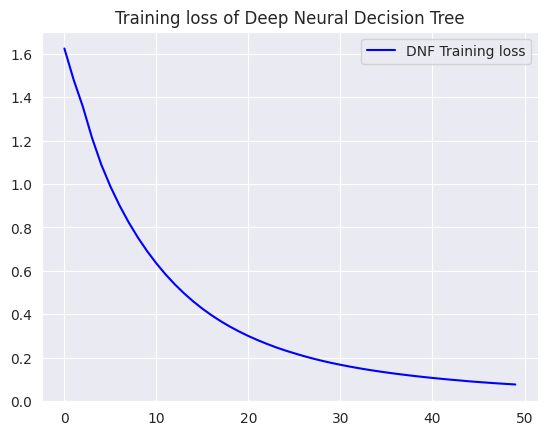

<Figure size 640x480 with 0 Axes>

In [34]:
acc = tree_history.history['categorical_accuracy']
# val_acc = model_history.history['val_accuracy']
loss = tree_history.history['loss']
# val_loss = model_history.history['val_loss']

epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='DNF Training loss')
plt.title('Training loss of Deep Neural Decision Tree')
plt.legend(loc=0)
plt.figure()


plt.show()

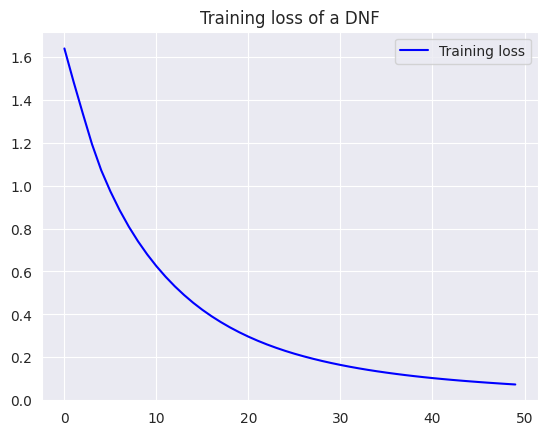

<Figure size 640x480 with 0 Axes>

In [33]:
acc = forest_history.history['categorical_accuracy']
# val_acc = model_history.history['val_accuracy']
loss = forest_history.history['loss']
# val_loss = model_history.history['val_loss']

epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss of a DNF')
plt.legend(loc=0)
plt.figure()


plt.show()

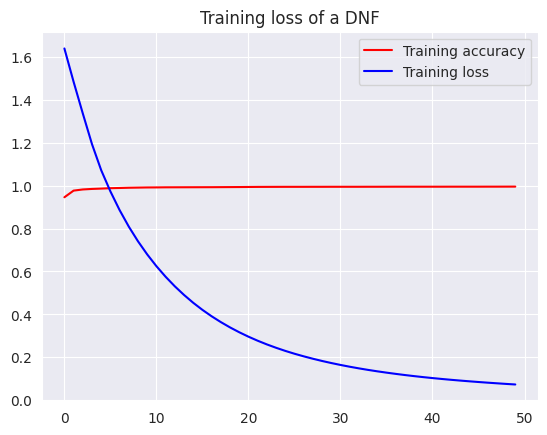

<Figure size 640x480 with 0 Axes>

In [35]:
acc = forest_history.history['categorical_accuracy']
# val_acc = model_history.history['val_accuracy']
loss = forest_history.history['loss']
# val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss of a DNF')
plt.legend(loc=0)
plt.figure()


plt.show()

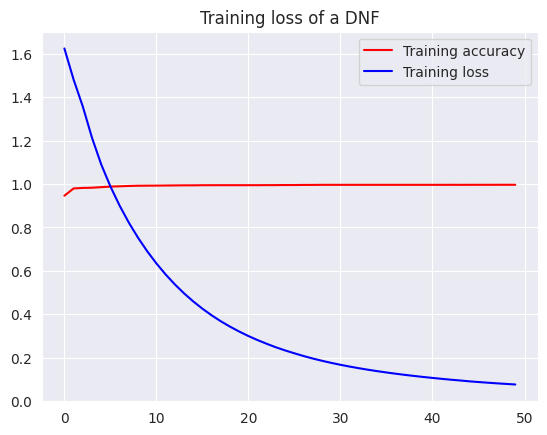

<Figure size 640x480 with 0 Axes>

In [37]:
acc = tree_history.history['categorical_accuracy']
# val_acc = model_history.history['val_accuracy']
loss = tree_history.history['loss']
# val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss of a DNF')
plt.legend(loc=0)
plt.figure()


plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

test_dataset = get_dataset(x_test_features, y_test, batch_size=128)

y_pred = forest_model.predict(test_dataset)

    
auroc = roc_auc_score(y_test, y_pred)
print("AUROC:", auroc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step
AUROC: 0.8013918938125016
